In [24]:
import numpy                 as np
import matplotlib.pyplot     as plt
import pandas                as pd
import yfinance              as yf
import seaborn               as sns
import random
from   scipy.stats import percentileofscore
from   scipy.stats import ttest_1samp
from   statsmodels.stats.multitest import fdrcorrection

In [2]:
stock_data=pd.read_parquet('sp500_20161229.parquet')
stock_data.dropna(axis=1,inplace=True)
tickers=stock_data.columns[1:]

In [3]:
def trend_following(ticker,A, B,stock_data=stock_data):
           
    Stock = pd.DataFrame(stock_data[ticker].copy())
    Stock.columns=['Return']
    
    Stock['Cumulated_return']=np.cumprod(1+Stock['Return'])-1
    
    Rolling_mean_A = Stock['Cumulated_return'].rolling(A).mean()
    Rolling_mean_B = Stock['Cumulated_return'].rolling(B).mean()

    Stock['Rolling_mean_A'] = Rolling_mean_A
    Stock['Rolling_mean_B'] = Rolling_mean_B
    
    Stock.dropna(inplace=True)

    Stock['Trade_sign'] = np.where(Stock['Rolling_mean_A'] > Stock['Rolling_mean_B'], 1, 0)    
    Stock['Trade_sign']=Stock['Trade_sign'].shift(1)
    Stock.dropna(inplace=True)
    Stock['Strategy_Return'] =Stock['Return']*Stock['Trade_sign']

    return Stock['Strategy_Return']

In [4]:
def Mean_reverting(ticker,k,Vol_window_length,stock_data=stock_data):
    
    Stock = pd.DataFrame(stock_data[ticker].copy())
    Stock.columns=['Return']

    Stock['Mean_return'] = Stock['Return'].rolling(Vol_window_length).mean()
    Stock['Vol_return'] = Stock['Return'].rolling(Vol_window_length).std()

    Stock.dropna(inplace=True)

    Stock['Trade_sign'] = np.where(Stock['Return']-Stock['Mean_return'] > k*Stock['Vol_return'] , -1,1)
    Stock.loc[(Stock['Return']-Stock['Mean_return'] > k*Stock['Vol_return']) & (Stock['Return']-Stock['Mean_return'] < 0), 'Trade_sign'] = -1

    Stock['Trade_sign']=Stock['Trade_sign'].shift(1)
    Stock.dropna(inplace=True)

    Stock['Strategy_Return']= Stock['Return']*Stock['Trade_sign']
    
    return Stock['Strategy_Return']

In [5]:
def calculate_quantile(row, window):
    
    prev_log_returns = row[-window:]
    quantile = percentileofscore(prev_log_returns, row[-1])
    return quantile

def Conditional_strategy(ticker,Lower_treshhold,Upper_treshhold,stock_data=stock_data):
    
    Empirical_distribution_window=40
    Stock = pd.DataFrame(stock_data[ticker].copy())
    Stock.columns=['Return']
    Stock['Quantile'] = Stock['Return'].rolling(window=Empirical_distribution_window).apply(calculate_quantile, args=(Empirical_distribution_window,), raw=True)
    Stock.dropna(inplace=True)
    Stock['Trade_sign'] = np.where(Stock['Quantile'] > Upper_treshhold , 0, 1)
    Stock.loc[(Stock['Quantile'] > Lower_treshhold ) & (Stock['Quantile'] < 50), 'Trade_sign'] = -1
    Stock['Strategy_Return'] = Stock['Return']
    Stock['Trade_sign']= Stock['Trade_sign'].shift(1)
    Stock.dropna(inplace=True)
    Stock['Strategy_Return'] *= Stock['Trade_sign']

    return Stock['Strategy_Return']

In [6]:
Min_A, Max_A = 10,40
Min_B, Max_B = 10,40
Window_A = np.arange(Min_A,Max_A,5)
Window_B = np.arange(Min_B,Max_B,5)

In [7]:
P_values=[]

In [8]:
Performances ={}
threshold=0.2

for ticker in tickers:
    Performances[ticker]=[]
    
    for A in Window_A:
        for B in Window_B:

            Performance = trend_following(ticker,A, B).values
            t_statistic, P_value = ttest_1samp(a=Performance, popmean=0, alternative='greater')
            P_values.append(P_value)
            if P_value < threshold :
                Performances[ticker].append(Performance)
            

In [9]:
k_window=np.arange(2,10)
Vol_window=np.arange(2,20)

In [10]:
Performances_MR ={}
threshold=0.2

for ticker in tickers:
    Performances_MR[ticker]=[]

    for k in k_window:
        for Vol_window_length in Vol_window:

            Performance_MR = Mean_reverting(ticker,k,Vol_window_length).values
            t_statistic, P_value = ttest_1samp(a=Performance_MR, popmean=0, alternative='greater')
            P_values.append(P_value)
            if P_value < threshold :
                Performances_MR[ticker].append(Performance_MR)

In [11]:
Lower_treshhold,Upper_treshhold=20,80
Performances_cond={}
for ticker in tickers:
    Performances_cond[ticker]=[]
    Performance_cond = Conditional_strategy(ticker,Lower_treshhold,Upper_treshhold,stock_data=stock_data).values
    t_statistic, P_value = ttest_1samp(a=Performance_cond, popmean=0, alternative='greater')
    P_values.append(P_value)
    
    if P_value < threshold :
        Performances_cond[ticker].append(Performance_cond)

In [12]:
fraction=0
for ticker in tickers:
    fraction+= (len(Performances[ticker])+len(Performances_MR[ticker])+len(Performances_cond[ticker]))
fraction/=(((k_window.shape[0]*Vol_window.shape[0])+(Window_A.shape[0]*Window_B.shape[0])+1)*len(tickers))
print(f'Fraction of selected strategies = {fraction*100:.2f}%')

Fraction of selected strategies = 77.18%


Let us plot the performance of one of these strategies :

In [13]:
random_ticker = random.choice(tickers)
while (len(Performances[random_ticker])==0):
    random_ticker = random.choice(tickers)

startegy_return=Performances[random_ticker][0]
startegy_cumulative_return=np.cumprod(1+startegy_return)-1

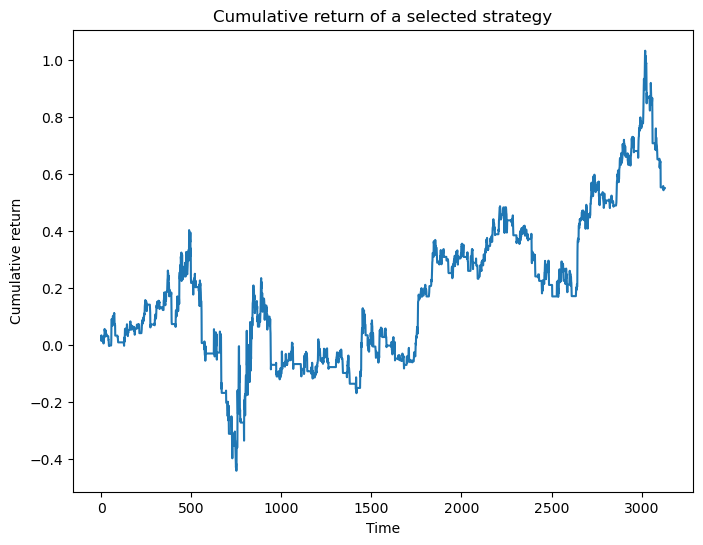

In [14]:
fig,ax=plt.subplots(figsize=(8,6))


ax.plot(startegy_cumulative_return)
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative return')
ax.set_title('Cumulative return of a selected strategy')

plt.show()

By inspecting this stratey we notice that indeed the cumulative return is higher then zero and thus this strategy would have a high chance of having a strictly positive return.

#### FDR

In [15]:
def Sort_P_values(P_values):
    P_value_rank={}

    sorted_P_values = sorted(P_values)
    
    for i, P_value in enumerate(sorted_P_values):
        P_value_rank[P_value]=i+1

    return P_value_rank

In [16]:
P_value_rank=Sort_P_values(P_values)
m=len(P_values)

In [17]:
Performances_FDR ={}

for ticker in tickers:
    Performances_FDR[ticker]=[]

    if len(Performances[ticker])==0:
         continue
    
    for Performance in Performances[ticker]:
        t_statistic, P_value = ttest_1samp(a=Performance, popmean=0, alternative='greater')
        if P_value < P_value_rank[P_value]*threshold/m :
            Performances_FDR[ticker].append(Performance)

In [18]:
Performances_FDR_MR ={}

for ticker in tickers:
    Performances_FDR_MR[ticker]=[]
    if Performances_MR[ticker]==[]:
         continue
    for Performance_MR in Performances_MR[ticker]:
            t_statistic, P_value = ttest_1samp(a=Performance_MR, popmean=0, alternative='greater')
            if P_value < P_value_rank[P_value]*threshold/m  :
                Performances_FDR_MR[ticker].append(Performance_MR)

In [19]:
Lower_treshhold,Upper_treshhold=20,80
Performances_FDR_cond={}
for ticker in tickers:
    Performances_FDR_cond[ticker]=[]
    if Performances_cond[ticker]==[]:
        continue
    Performance_cond = Performances_cond[ticker][0]
    t_statistic, P_value = ttest_1samp(a=Performance_cond, popmean=0, alternative='greater')
    if P_value < P_value_rank[P_value]*threshold/m  :
        Performances_FDR_cond[ticker].append(Performance_cond)

In [20]:
fraction_FDR=0
for ticker in tickers:
    fraction_FDR+= (len(Performances_FDR[ticker])+len(Performances_FDR_MR[ticker])+len(Performances_FDR_cond[ticker]))
    
fraction_FDR/=(((k_window.shape[0]*Vol_window.shape[0])+(Window_A.shape[0]*Window_B.shape[0])+1)*len(tickers))
print(f'Fraction of selected strategies = {fraction_FDR*100:.2f}%')

Fraction of selected strategies = 64.92%


Thanks to FDR, we are able to be more selective in terms of startegies to pass the filter 

Using rolling window

In [39]:
Strategies_df=pd.DataFrame()
for ticker in tickers[:3]:
    for A in Window_A:
        for B in Window_B:
            df=pd.DataFrame()
            Performance = trend_following(ticker,A, B)
            Strategies_df[f'{ticker} MA {A=} {B=}']=Performance


    for k in k_window:
        for Vol_window_length in Vol_window:
            df=pd.DataFrame()
            Performance_MR = Mean_reverting(ticker,k,Vol_window_length)
            Strategies_df[f'{ticker} MR {k=} Window={Vol_window_length}']=Performance_MR

    Performance_cond = Conditional_strategy(ticker,Lower_treshhold,Upper_treshhold,stock_data=stock_data)
    Strategies_df [f'{ticker} Cond']=Performance_cond
    

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_2796\1436648417.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Strategies_df[f'{ticker} MR {k=} Window={Vol_window_length}']=Performance_MR
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_2796\1436648417.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Strategies_df[f'{ticker} MR {k=} Window={Vol_window_length}']=Performance_MR
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_2796\1436648417.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

In [40]:
Strategies_df.dropna(inplace=True)

In [42]:
window_size = 252
alpha = 0.2

In [61]:
def t_test_positive_window(data, window_size):
    p_values = data.rolling(window=window_size).apply(lambda x: ttest_1samp(a=x,popmean=0, alternative='greater')[1])
    return p_values

In [62]:
p_values_rolling = Strategies_df.apply(lambda col: t_test_positive_window(col, window_size))

In [63]:
p_values_rolling_copy=p_values_rolling.copy()

In [68]:
p_values_rolling_copy.fillna(1,inplace=True)

In [69]:
p_values_rolling_copy=p_values_rolling_copy.loc[253:]

In [71]:
fdr_rejected, fdr_adjusted_p_values = fdrcorrection(p_values_rolling.values.flatten(), alpha=alpha)
fdr_rejected = fdr_rejected.reshape(p_values_rolling.shape)

# Step 3: Create new dataframe with 0s and 1s based on FDR correction
selected_strategies = pd.DataFrame(index=Strategies_df.index, columns=Strategies_df.columns, dtype=int)
selected_strategies[fdr_rejected == True] = 1
selected_strategies[fdr_rejected == False] = 0


In [81]:
Fraction_rolling=(selected_strategies.sum(axis=1)/len(selected_strategies.columns))*100

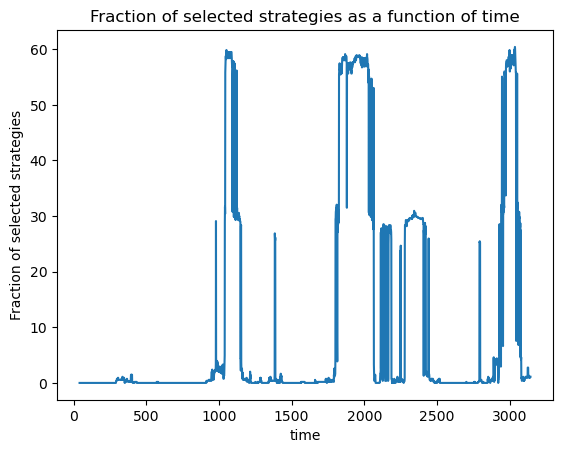

In [84]:
plt.plot(Fraction_rolling)
plt.xlabel('time')
plt.ylabel('Fraction of selected strategies')
plt.title('Fraction of selected strategies as a function of time')
plt.show()

We notice that the fraction of the selected strategies varies deeply as a function of time, sometimes almost no strategy performs well and for other times more than half are selected.\
This further highlightes the idea that no strategy works well all the time and that performance of startegies depend on the state of the market.

In [ ]:
Strategies_df
    for A in Window_A:
        for B in Window_B:
            df=pd.DataFrame()
            Performance = trend_following(ticker,A, B)
            Strategies_df[f'{ticker} MA {A=} {B=}']=Performance


    for k in k_window:
        for Vol_window_length in Vol_window:
            df=pd.DataFrame()
            Performance_MR = Mean_reverting(ticker,k,Vol_window_length)
            Strategies_df[f'{ticker} MR {k=} Window={Vol_window_length}']=Performance_MR

    Performance_cond = Conditional_strategy(ticker,Lower_treshhold,Upper_treshhold,stock_data=stock_data)
    Strategies_df [f'{ticker} Cond']=Performance_cond

In [85]:
Strategies_df

,A MA A=10 B=10,A MA A=10 B=15,A MA A=10 B=20,A MA A=10 B=25,A MA A=10 B=30,A MA A=10 B=35,A MA A=15 B=10,A MA A=15 B=15,A MA A=15 B=20,A MA A=15 B=25,...,ABC MR k=9 Window=11,ABC MR k=9 Window=12,ABC MR k=9 Window=13,ABC MR k=9 Window=14,ABC MR k=9 Window=15,ABC MR k=9 Window=16,ABC MR k=9 Window=17,ABC MR k=9 Window=18,ABC MR k=9 Window=19,ABC Cond
40,-0.0,-0.010624,-0.010624,-0.010624,-0.010624,-0.010624,-0.000000,-0.0,-0.010624,-0.010624,...,-0.000870,-0.000870,-0.000870,-0.000870,-0.000870,-0.000870,-0.000870,-0.000870,-0.000870,-0.000870
41,-0.0,-0.002753,-0.002753,-0.002753,-0.002753,-0.002753,-0.000000,-0.0,-0.002753,-0.002753,...,-0.010009,-0.010009,-0.010009,-0.010009,-0.010009,-0.010009,-0.010009,-0.010009,-0.010009,0.010009
42,-0.0,-0.001104,-0.001104,-0.001104,-0.001104,-0.001104,-0.000000,-0.0,-0.001104,-0.001104,...,-0.007692,-0.007692,-0.007692,-0.007692,-0.007692,-0.007692,-0.007692,-0.007692,-0.007692,-0.007692
43,0.0,0.004699,0.004699,0.004699,0.004699,0.004699,0.000000,0.0,0.004699,0.004699,...,0.009524,0.009524,0.009524,0.009524,0.009524,0.009524,0.009524,0.009524,0.009524,0.009524
44,0.0,0.005777,0.005777,0.005777,0.005777,0.005777,0.000000,0.0,0.005777,0.005777,...,0.004827,0.004827,0.004827,0.004827,0.004827,0.004827,0.004827,0.004827,0.004827,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3140,-0.0,-0.025323,-0.025323,-0.025323,-0.025323,-0.000000,-0.000000,-0.0,-0.025323,-0.025323,...,-0.013690,-0.013690,-0.013690,-0.013690,-0.013690,-0.013690,-0.013690,-0.013690,-0.013690,0.013690
3141,0.0,0.000000,0.012745,0.012745,0.012745,0.000000,0.012745,0.0,0.012745,0.012745,...,-0.019844,-0.019844,-0.019844,-0.019844,-0.019844,-0.019844,-0.019844,-0.019844,-0.019844,0.019844
3142,-0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.013553,-0.0,-0.013553,-0.013553,...,-0.006306,-0.006306,-0.006306,-0.006306,-0.006306,-0.006306,-0.006306,-0.006306,-0.006306,-0.006306
3143,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.002453,0.0,0.002453,0.002453,...,-0.041416,-0.041416,-0.041416,-0.041416,-0.041416,-0.041416,-0.041416,-0.041416,-0.041416,0.041416


Let us plot the average return of four strategies as a function of time

First strategy MA A=15 B=35:

In [119]:
A=Window_A[1]
B=Window_B[5]
strat1_name=f'MA {A=} {B=}'
strat1 = [col for col in Strategies_df.columns if strat1_name in col]
strat1_performance=Strategies_df[strat1]

First strategy bis MA A=35 B=15:

In [117]:
A=Window_A[5]
B=Window_B[1]
strat1_bis_name=f'MA {A=} {B=}'
strat1_bis = [col for col in Strategies_df.columns if strat1_bis_name in col]
strat1_bis_performance=Strategies_df[strat1_bis]

Second strategy MR k=5 Window=7

In [106]:
k=k_window[3]
Vol_window_length=Vol_window[5]
strat2_name=f'MR {k=} Window={Vol_window_length}'
strat2 = [col for col in Strategies_df.columns if strat2_name in col]
strat2_performance=Strategies_df[strat2]

Third strategy conditional strategy

In [107]:
strat3_name='Cond'
strat3 = [col for col in Strategies_df.columns if strat3_name in col]
strat3_performance=Strategies_df[strat3]

In [120]:
mean_strat1_performance=strat1_performance.mean(axis=1)
mean_strat1_bis_performance=strat1_bis_performance.mean(axis=1)
mean_strat2_performance=strat2_performance.mean(axis=1)
mean_strat3_performance=strat3_performance.mean(axis=1)

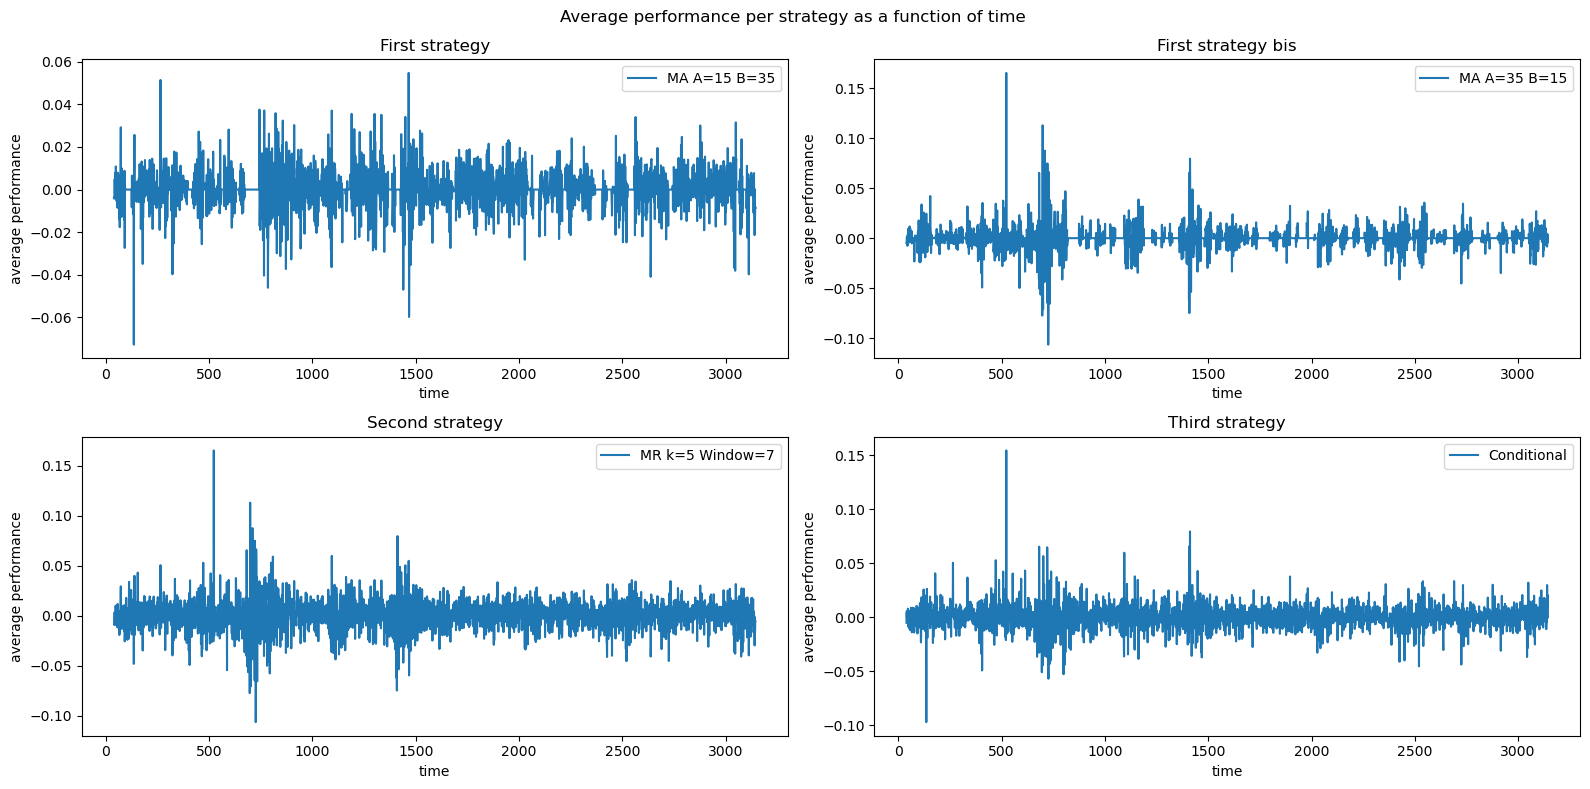

In [123]:
fig,ax=plt.subplots(2,2,figsize=(16,8))
ax[0,0].plot(mean_strat1_performance ,label='MA A=15 B=35')
ax[0,1].plot(mean_strat1_bis_performance ,label='MA A=35 B=15')
ax[1,0].plot(mean_strat2_performance, label='MR k=5 Window=7')
ax[1,1].plot(mean_strat3_performance, label='Conditional')
fig.suptitle('Average performance per strategy as a function of time ')
ax[0,0].set_title('First strategy')
ax[0,1].set_title('First strategy bis')
ax[1,0].set_title('Second strategy')
ax[1,1].set_title('Third strategy')

for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel('time')
        ax[i,j].set_ylabel('average performance')
        ax[i,j].legend()
plt.tight_layout()
plt.show()

We notice that performances of the strategy are highly volatile.We notice Some strategies (first row) have periods of almost 0 return (this is because MA startegies as defined in this code don't allow short selling so they traverse periods where the investor just buys and holds or liquidates his position).\
We also notice that at certain times the absoute value of returns are high for all the startegies at the same time (this could be due to higher volatility in one or some of the underlying stocks that are being traded)